In [1]:
# Python 2 & 3 Compatibility
from __future__ import print_function, division

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
import sklearn.preprocessing
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
cars = pd.read_pickle('cars_clean.pkl')

cars['log_price'] = np.log(cars.price)
cars['log_mileage'] = np.log(cars.mileage)
cars['log_age'] = np.log(cars.age)

# drop make categories
cols = [c for c in cars.columns if 'Make' not in c]
cars2 = cars[cols]

# make, model and numbers only
cars3 = cars2.drop(['title','subtitle','url','auction','num_bids'],1)
cars3.shape

/Users/marc/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(29362, 54)

In [2]:
# Drop NaNs = 
cars3 = cars3.dropna(axis=0,how='any')
cars3 = cars3.dropna(axis=1,how='any')

cars3.describe()

,price,mileage,year,van,hatch,pickup,twodoor,fourdoor,convertible,hardtop,...,drivetype_ct,forsaleby_ct,driveside_ct,transmission_ct,condition_ct,vehicletitle_ct,fuel_ct,log_price,log_mileage,log_age
count,24565.000,24565.000,24565.000,24565.000,24565.000,24565.000,24565.000,24565.000,24565.000,24565.000,...,24565.000,24565.000,24565.000,24565.000,24565.000,24565.000,24565.000,24565.000,24565.000,24565.000
mean,10888.058,106268.981,1995.607,0.038,0.026,0.108,0.014,0.026,0.113,0.004,...,0.857,0.892,0.346,0.949,1.000,0.998,0.888,8.719,11.207,2.617
std,12776.307,100729.526,17.493,0.192,0.158,0.310,0.116,0.158,0.317,0.067,...,0.351,0.311,0.476,0.225,0.000,0.046,0.317,1.177,1.003,1.350
min,0.990,1000.000,1891.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,1.000,0.000,0.000,-0.010,6.908,-9.210
25%,3000.000,50000.000,1986.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1.000,1.000,0.000,1.000,1.000,1.000,1.000,8.006,10.820,2.197
50%,6929.290,92570.000,2002.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1.000,1.000,0.000,1.000,1.000,1.000,1.000,8.844,11.436,2.708
75%,14200.000,140282.000,2008.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,9.561,11.851,3.434
max,210100.000,999999.000,2017.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,2.000,2.000,2.000,2.000,1.000,1.000,2.000,12.255,13.816,4.836


In [3]:
# g = sns.FacetGrid(cars3.sort_values('make',ascending=True), col="make", col_wrap=5)
# g = (g.map(plt.scatter, "mileage","log_price", edgecolor="w"))

In [4]:
# g = sns.FacetGrid(cars3.sort_values('make',ascending=True), col="make", col_wrap=5)
# g = (g.map(plt.scatter, "age","log_price", color="c",edgecolor="w"))

In [5]:
# g = sns.FacetGrid(cars3.sort_values('make',ascending=True), col="make", col_wrap=5)
# g = (g.map(plt.hist, "log_price", color="g"))

In [6]:
# Filter outliers
cars3 = cars3[
  (cars3.bodytype_ct>=1) 
& (cars3.drivetype_ct>=1) 
& (cars3.forsaleby_ct>=1)
& (cars3.transmission_ct>=1)
& (cars3.vehicletitle_ct>=1) 
& (cars3.fuel_ct>=1)
& (cars3.price>=1000)
& (cars3.year>=1950)
& (cars3.mileage<=400000)
& (cars3.cylinders>2)
]

# drop category count columns
cols = [c for c in cars3.columns if '_ct' not in c]
cars3 = cars3[cols]

cars3.describe()

,price,mileage,year,van,hatch,pickup,twodoor,fourdoor,convertible,hardtop,...,title_is_clear,age,gas,diesel,electric,ethanol,cng,log_price,log_mileage,log_age
count,14131.000,14131.000,14131.000,14131.000,14131.000,14131.000,14131.000,14131.000,14131.000,14131.000,...,14131.000,14131.000,14131.000,14131.000,14131.000,14131.000,14131.000,14131.000,14131.000,14131.000
mean,11683.383,94566.462,1998.908,0.044,0.030,0.131,0.010,0.031,0.127,0.004,...,0.859,18.092,0.933,0.050,0.014,0.002,0.001,8.928,11.136,2.425
std,12656.903,61504.476,15.051,0.204,0.170,0.337,0.098,0.174,0.333,0.064,...,0.348,15.051,0.251,0.218,0.119,0.046,0.031,0.951,0.973,1.420
min,1000.000,1000.000,1950.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,6.908,6.908,-9.210
25%,3800.000,46507.000,1992.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1.000,8.000,1.000,0.000,0.000,0.000,0.000,8.243,10.747,2.079
50%,7750.000,87693.000,2004.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1.000,13.000,1.000,0.000,0.000,0.000,0.000,8.955,11.382,2.565
75%,15000.000,133000.000,2009.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1.000,25.000,1.000,0.000,0.000,0.000,0.000,9.616,11.798,3.219
max,189999.000,398862.000,2017.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,67.000,1.000,1.000,1.000,1.000,1.000,12.155,12.896,4.205


In [7]:
# g = sns.FacetGrid(cars3.sort_values('make',ascending=True), col="make", col_wrap=5)
# g = (g.map(plt.scatter, "mileage","log_price", edgecolor="w"))

In [8]:
# g = sns.FacetGrid(cars3.sort_values('make',ascending=True), col="make", col_wrap=5)
# g = (g.map(plt.scatter, "age","log_price", color="c",edgecolor="w"))

In [9]:
# g = sns.FacetGrid(cars3.sort_values('make',ascending=True), col="make", col_wrap=5)
# g = (g.map(plt.hist, "log_price", color="g"))

In [10]:
cars3.columns

Index(['price', 'mileage', 'model', 'year', 'van', 'hatch', 'pickup',
       'twodoor', 'fourdoor', 'convertible', 'hardtop', 'coupe', 'suv', 'ttop',
       'sedan', 'wagon', 'cylinders', 'awd', 'fwd', 'rwd', 'private', 'dealer',
       'make', 'leftdrive', 'rightdrive', 'warranty', 'manual', 'auto', 'used',
       'new', 'cpo', 'title_clear', 'title_salvage', 'title_rebuilt',
       'title_flood', 'title_lemon', 'title_is_clear', 'age', 'gas', 'diesel',
       'electric', 'ethanol', 'cng', 'log_price', 'log_mileage', 'log_age'],
      dtype='object')

In [11]:
# reordering columns
cars3 = cars3[['make','log_price', 'mileage', 'cylinders','age', 'van', 'hatch', 'pickup',
        'twodoor', 'fourdoor', 'convertible', 'hardtop', 'coupe', 'suv', 'ttop',
        'sedan', 'wagon','awd', 'fwd', 'rwd', 'private', 'dealer','leftdrive', 'rightdrive', 
        'warranty', 'manual', 'auto', 'used','new', 'cpo', 
        'title_clear', 'title_salvage', 'title_rebuilt','title_flood', 'title_lemon','title_is_clear',
        'gas', 'diesel','electric', 'ethanol', 'cng']].copy()

cars4 = cars3.copy() # for use in regularization w/ normalized features

In [12]:
cars3.columns

Index(['make', 'log_price', 'mileage', 'cylinders', 'age', 'van', 'hatch',
       'pickup', 'twodoor', 'fourdoor', 'convertible', 'hardtop', 'coupe',
       'suv', 'ttop', 'sedan', 'wagon', 'awd', 'fwd', 'rwd', 'private',
       'dealer', 'leftdrive', 'rightdrive', 'warranty', 'manual', 'auto',
       'used', 'new', 'cpo', 'title_clear', 'title_salvage', 'title_rebuilt',
       'title_flood', 'title_lemon', 'title_is_clear', 'gas', 'diesel',
       'electric', 'ethanol', 'cng'],
      dtype='object')

## OLS #1

In [13]:
### Make variable string
variables = list(cars3.columns)

remove = ['make','price','log_price','model','year','log_age','log_mileage']
for x in remove:
    try:
        variables.remove(x)
    except ValueError:
       continue 

In [14]:
### Make variable string
x_string = ''
for cat in variables:
    x_string += ' + ' + cat
print(x_string,'','variable count:',len(variables)-2,sep='\n')

 + mileage + cylinders + age + van + hatch + pickup + twodoor + fourdoor + convertible + hardtop + coupe + suv + ttop + sedan + wagon + awd + fwd + rwd + private + dealer + leftdrive + rightdrive + warranty + manual + auto + used + new + cpo + title_clear + title_salvage + title_rebuilt + title_flood + title_lemon + title_is_clear + gas + diesel + electric + ethanol + cng

variable count:
37


In [15]:
y1, X1 = patsy.dmatrices('''log_price ~ 
mileage + cylinders + age + van + hatch + pickup + twodoor + fourdoor + convertible + hardtop + coupe + suv + ttop + sedan + wagon + awd + fwd + rwd + private + leftdrive + rightdrive + warranty + manual + new + cpo + title_is_clear + gas + electric + ethanol + cng
''', data=cars3, return_type="dataframe")

# Create model
model1 = sm.OLS(y1, X1)
# Fit model to training set
fit1 = model1.fit()
# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     481.4
Date:                Fri, 14 Jul 2017   Prob (F-statistic):               0.00
Time:                        05:45:08   Log-Likelihood:                -14361.
No. Observations:               14131   AIC:                         2.878e+04
Df Residuals:                   14100   BIC:                         2.902e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          9.3452      0.390     23.933      0.000         8.580    10.111
mileage        -8.012e-06   1.06e-07    -75.829      0.000     -8.22e-06  -7.8e-06
cylinders          0.1173      0.004     27.958      0.000         0.109     0.126
age               -0.0108      0.000    -22.456      0.000        -0.012    -0.010
van                0.2415      0.065      3.701      0.000         0.114     0.369
hatch              0.0567      0.068      0.837      0.402        -0.076     0.189
pickup             0.0517      0.062      0.836      0.403        -0.069     0.173
twodoor            0.2049      0.072      2.861      0.004         0.065     0.345
fourdoor           0.0480      0.057      0.846      0.398        -0.063     0.159
convertible        0.3061      0.061      4.994      0.000         0.186     0.426
hardtop            0.5273      0.097      5.457      0.000         0.338     0.717
coupe              0.2780      0.060      4.602      0.000         0.160     0.396
suv                0.1259      0.061      2.063      0.039         0.006     0.246
ttop               0.5416      0.122      4.438      0.000         0.302     0.781
sedan             -0.0163      0.059     -0.275      0.783        -0.133     0.100
wagon              0.0096      0.067      0.144      0.886        -0.122     0.141
awd                0.4847      0.387      1.251      0.211        -0.275     1.244
fwd               -0.0093      0.387     -0.024      0.981        -0.769     0.750
rwd                0.2997      0.387      0.774      0.439        -0.460     1.059
private           -0.1254      0.013     -9.319      0.000        -0.152    -0.099
leftdrive          0.0089      0.012      0.748      0.454        -0.014     0.032
rightdrive         0.0008      0.044      0.018      0.986        -0.086     0.087
warranty           0.4720      0.021     22.435      0.000         0.431     0.513
manual             0.2973      0.016     18.719      0.000         0.266     0.328
new                0.1706      0.154      1.105      0.269        -0.132     0.473
cpo                0.2187      0.056      3.894      0.000         0.109     0.329
title_is_clear     0.0491      0.019      2.654      0.008         0.013     0.085
gas               -0.7706      0.028    -27.913      0.000        -0.825    -0.717
electric          -0.3551      0.056     -6.377      0.000        -0.464    -0.246
ethanol           -0.5407      0.125     -4.320      0.000        -0.786    -0.295
cng               -1.1583      0.181     -6.406      0.000        -1.513    -0.804
==============================================================================
Omnibus:                      129.046   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              196.521
Skew:                   

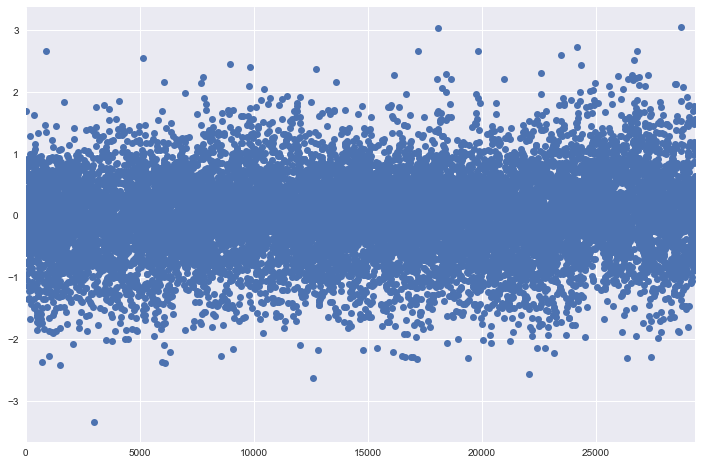

In [16]:
fit1.resid.plot(style='o', figsize=(12,8));

## Dummy Variable Trap

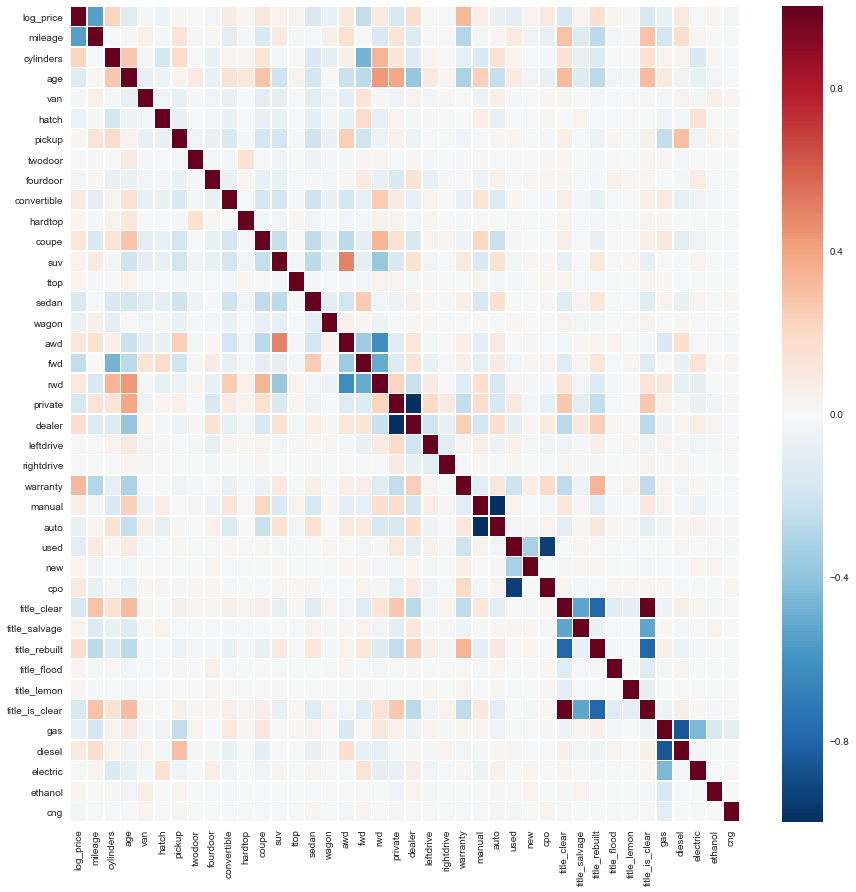

In [17]:
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(cars3.corr(),linewidths=.5,ax=ax);

In [18]:
# dropping dealer, auto, used, title categories, diesel
cars3 = cars3[['make','log_price', 'mileage', 'cylinders','age', 'van', 'hatch', 'pickup',
        'twodoor', 'fourdoor', 'convertible', 'hardtop', 'coupe', 'suv', 'ttop',
        'sedan', 'wagon','awd', 'fwd', 'rwd', 'private','leftdrive', 'rightdrive', 
        'warranty', 'manual','new', 'cpo', 
        'title_is_clear',
        'gas', 'electric', 'ethanol', 'cng']]

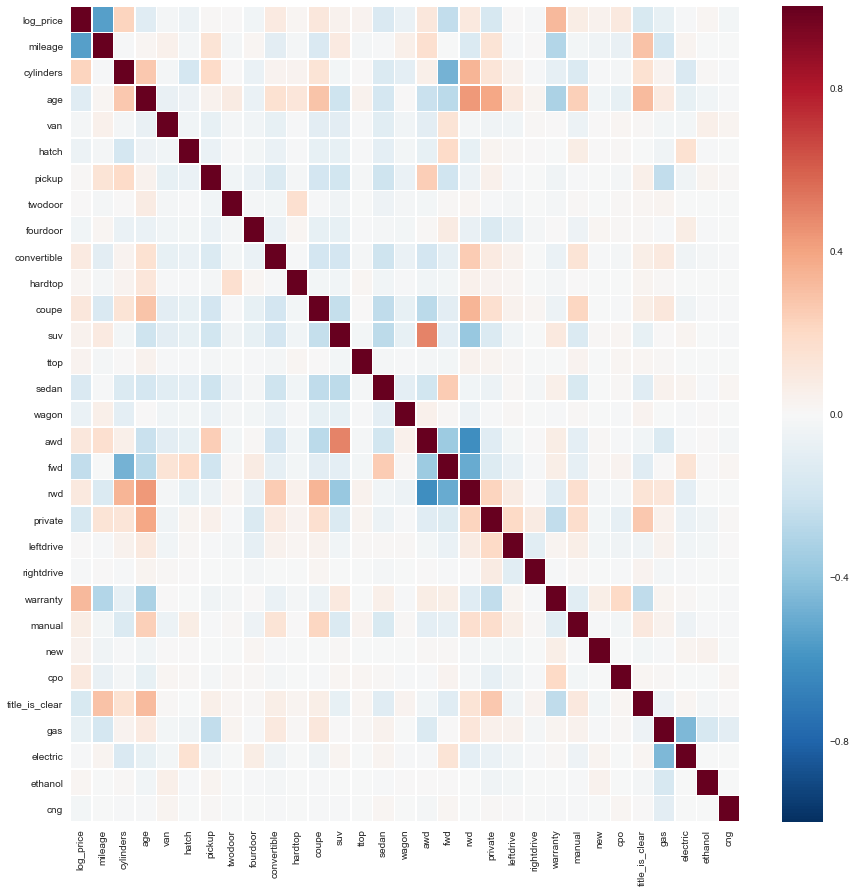

In [19]:
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(cars3.corr(),linewidths=.5,ax=ax);

## OLS # 2 -- Removing correlated categorical variables

In [20]:
### Make variable string
variables2 = list(cars3.columns)

remove = ['make','price','log_price','model','year','log_age','log_mileage']
for x in remove:
    try:
        variables2.remove(x)
    except ValueError:
       continue 

In [21]:
### Make variable string
x_string = ''
for cat in variables2:
    x_string += ' + ' + cat
print(x_string,'','variable count:',len(variables2)-2,sep='\n')

 + mileage + cylinders + age + van + hatch + pickup + twodoor + fourdoor + convertible + hardtop + coupe + suv + ttop + sedan + wagon + awd + fwd + rwd + private + leftdrive + rightdrive + warranty + manual + new + cpo + title_is_clear + gas + electric + ethanol + cng

variable count:
28


In [22]:
y2, X2 = patsy.dmatrices('''log_price ~ 
mileage + cylinders + age + van + hatch + pickup + twodoor + fourdoor + convertible + hardtop + coupe + suv + ttop + sedan + wagon + awd + fwd + rwd + private + leftdrive + rightdrive + warranty + manual + new + cpo + title_is_clear + gas + electric + ethanol + cng
''', data=cars3, return_type="dataframe")

# Create model
model2 = sm.OLS(y2, X2)
# Fit model to training set
fit2 = model2.fit()
# Print summary statistics of the model's performance
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     481.4
Date:                Fri, 14 Jul 2017   Prob (F-statistic):               0.00
Time:                        05:45:11   Log-Likelihood:                -14361.
No. Observations:               14131   AIC:                         2.878e+04
Df Residuals:                   14100   BIC:                         2.902e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          9.3452      0.390     23.933      0.000         8.580    10.111
mileage        -8.012e-06   1.06e-07    -75.829      0.000     -8.22e-06  -7.8e-06
cylinders          0.1173      0.004     27.958      0.000         0.109     0.126
age               -0.0108      0.000    -22.456      0.000        -0.012    -0.010
van                0.2415      0.065      3.701      0.000         0.114     0.369
hatch              0.0567      0.068      0.837      0.402        -0.076     0.189
pickup             0.0517      0.062      0.836      0.403        -0.069     0.173
twodoor            0.2049      0.072      2.861      0.004         0.065     0.345
fourdoor           0.0480      0.057      0.846      0.398        -0.063     0.159
convertible        0.3061      0.061      4.994      0.000         0.186     0.426
hardtop            0.5273      0.097      5.457      0.000         0.338     0.717
coupe              0.2780      0.060      4.602      0.000         0.160     0.396
suv                0.1259      0.061      2.063      0.039         0.006     0.246
ttop               0.5416      0.122      4.438      0.000         0.302     0.781
sedan             -0.0163      0.059     -0.275      0.783        -0.133     0.100
wagon              0.0096      0.067      0.144      0.886        -0.122     0.141
awd                0.4847      0.387      1.251      0.211        -0.275     1.244
fwd               -0.0093      0.387     -0.024      0.981        -0.769     0.750
rwd                0.2997      0.387      0.774      0.439        -0.460     1.059
private           -0.1254      0.013     -9.319      0.000        -0.152    -0.099
leftdrive          0.0089      0.012      0.748      0.454        -0.014     0.032
rightdrive         0.0008      0.044      0.018      0.986        -0.086     0.087
warranty           0.4720      0.021     22.435      0.000         0.431     0.513
manual             0.2973      0.016     18.719      0.000         0.266     0.328
new                0.1706      0.154      1.105      0.269        -0.132     0.473
cpo                0.2187      0.056      3.894      0.000         0.109     0.329
title_is_clear     0.0491      0.019      2.654      0.008         0.013     0.085
gas               -0.7706      0.028    -27.913      0.000        -0.825    -0.717
electric          -0.3551      0.056     -6.377      0.000        -0.464    -0.246
ethanol           -0.5407      0.125     -4.320      0.000        -0.786    -0.295
cng               -1.1583      0.181     -6.406      0.000        -1.513    -0.804
==============================================================================
Omnibus:                      129.046   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              196.521
Skew:                   

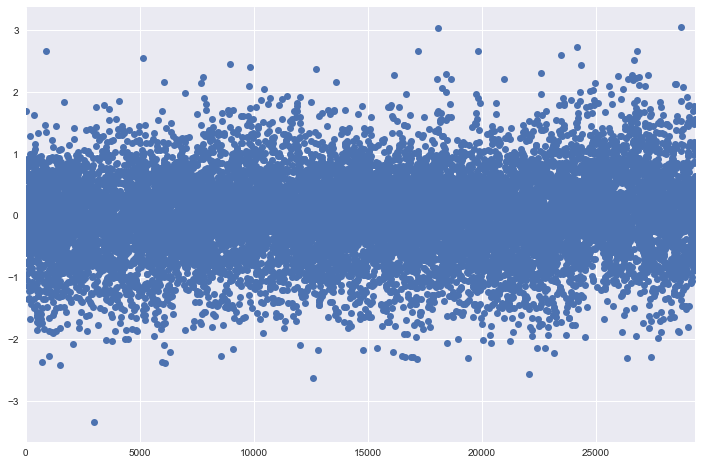

In [23]:
fit2.resid.plot(style='o', figsize=(12,8));

### J-Curve noticeable when slicing by age

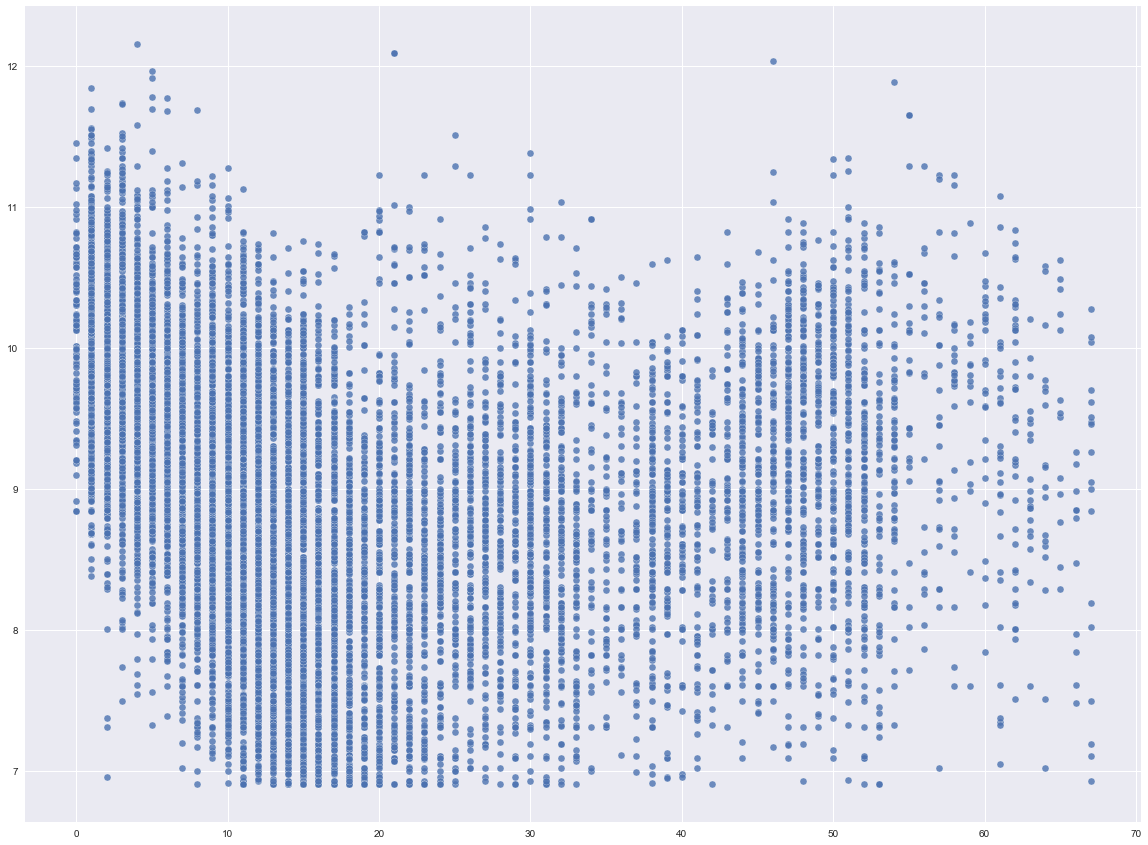

In [24]:
fig, ax = plt.subplots(figsize=(20,15)) 
plt.scatter(cars3.age,cars3.log_price,edgecolor="w",alpha=0.8)

## Classic Car = 25 years old according to government

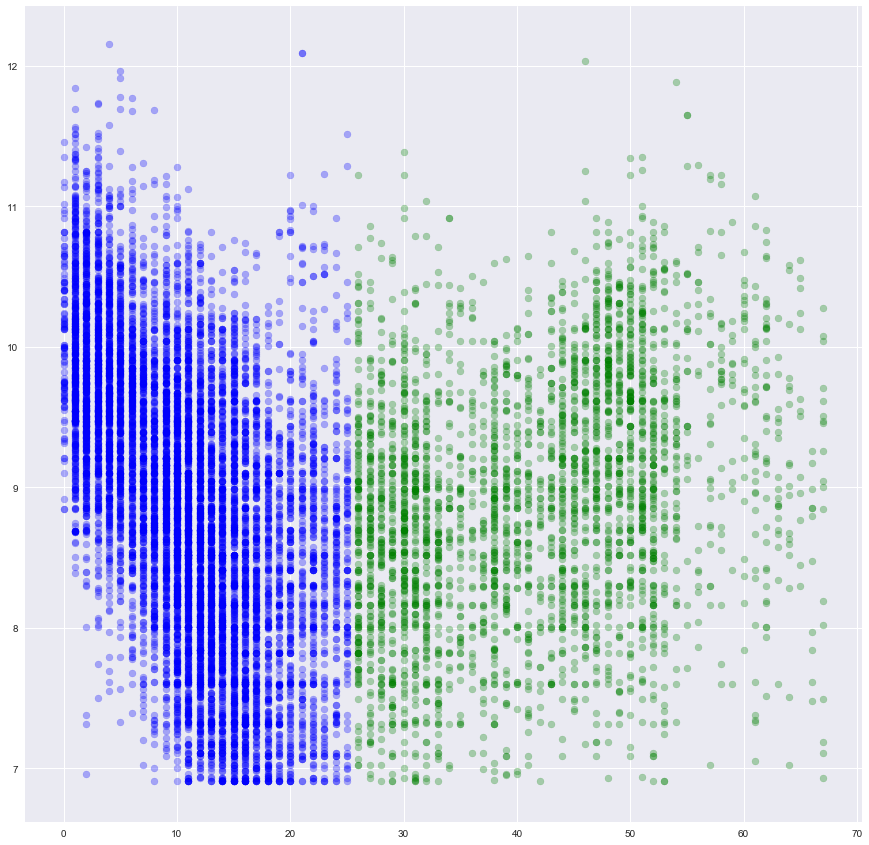

In [25]:
# classic car
threshold = 2017-1992
cars3['classic'] = [1 if x > threshold else 0 for x in cars3.age]

classics = cars3[cars3.classic==0].log_price
moderns = cars3[cars3.classic==1].log_price

classics_age = cars3[cars3.classic==0].age
moderns_age = cars3[cars3.classic==1].age

plt.subplots(figsize=(15,15)) 
plt.scatter(classics_age,classics,color='b',alpha=0.3)
plt.scatter(moderns_age,moderns,color='g', alpha=0.3)
plt.show()

In [26]:
# g = sns.FacetGrid(cars3, col="classic",size=8, aspect=1, sharex=False)
# g = (g.map(plt.scatter, "age", "log_price", 
#            edgecolor="w"))

### OLS #3 - Including Classic Car Variable

In [27]:
### Make variable string
variables3 = list(cars3.columns)

remove = ['make','price','log_price','model','year','log_age','log_mileage']
for x in remove:
    try:
        variables3.remove(x)
    except ValueError:
       continue

In [28]:
### Make variable string
x_string = ''
for cat in variables3:
    x_string += ' + ' + cat
print(x_string,'','variable count:',len(variables3)-2,sep='\n')

 + mileage + cylinders + age + van + hatch + pickup + twodoor + fourdoor + convertible + hardtop + coupe + suv + ttop + sedan + wagon + awd + fwd + rwd + private + leftdrive + rightdrive + warranty + manual + new + cpo + title_is_clear + gas + electric + ethanol + cng + classic

variable count:
29


In [29]:
y3, X3 = patsy.dmatrices('''log_price ~ 
mileage + cylinders + age + van + hatch + pickup + twodoor + fourdoor + convertible + hardtop + coupe + suv + ttop + sedan + wagon + awd + fwd + rwd + private + leftdrive + rightdrive + warranty + manual + new + cpo + title_is_clear + gas + electric + ethanol + cng + classic
''', data=cars3, return_type="dataframe")

# Create model
model3 = sm.OLS(y3, X3)
# Fit model to training set
fit3 = model3.fit()
# Print summary statistics of the model's performance
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     474.4
Date:                Fri, 14 Jul 2017   Prob (F-statistic):               0.00
Time:                        05:45:14   Log-Likelihood:                -14296.
No. Observations:               14131   AIC:                         2.866e+04
Df Residuals:                   14099   BIC:                         2.890e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          9.4108      0.389     24.209      0.000         8.649    10.173
mileage        -7.793e-06   1.07e-07    -72.896      0.000        -8e-06 -7.58e-06
cylinders          0.1216      0.004     28.990      0.000         0.113     0.130
age               -0.0192      0.001    -21.956      0.000        -0.021    -0.017
van                0.2235      0.065      3.440      0.001         0.096     0.351
hatch              0.0343      0.067      0.508      0.611        -0.098     0.166
pickup             0.0399      0.062      0.648      0.517        -0.081     0.160
twodoor            0.2014      0.071      2.824      0.005         0.062     0.341
fourdoor           0.0346      0.056      0.613      0.540        -0.076     0.145
convertible        0.2944      0.061      4.825      0.000         0.175     0.414
hardtop            0.5281      0.096      5.491      0.000         0.340     0.717
coupe              0.2542      0.060      4.225      0.000         0.136     0.372
suv                0.1091      0.061      1.794      0.073        -0.010     0.228
ttop               0.4906      0.122      4.035      0.000         0.252     0.729
sedan             -0.0281      0.059     -0.476      0.634        -0.144     0.088
wagon             -0.0044      0.067     -0.066      0.947        -0.135     0.126
awd                0.4383      0.386      1.136      0.256        -0.318     1.194
fwd               -0.0495      0.386     -0.128      0.898        -0.805     0.706
rwd                0.2495      0.386      0.647      0.518        -0.506     1.005
private           -0.1278      0.013     -9.540      0.000        -0.154    -0.102
leftdrive          0.0061      0.012      0.513      0.608        -0.017     0.029
rightdrive        -0.0206      0.044     -0.470      0.639        -0.107     0.065
warranty           0.4454      0.021     21.134      0.000         0.404     0.487
manual             0.3019      0.016     19.088      0.000         0.271     0.333
new                0.1561      0.154      1.016      0.310        -0.145     0.457
cpo                0.2102      0.056      3.760      0.000         0.101     0.320
title_is_clear     0.0682      0.019      3.686      0.000         0.032     0.105
gas               -0.7602      0.027    -27.645      0.000        -0.814    -0.706
electric          -0.3510      0.055     -6.333      0.000        -0.460    -0.242
ethanol           -0.5464      0.125     -4.386      0.000        -0.791    -0.302
cng               -1.1185      0.180     -6.213      0.000        -1.471    -0.766
classic            0.3236      0.028     11.435      0.000         0.268     0.379
==============================================================================
Omnibus:                      160.800   Durbin-Watson:                   1.870
Prob(Omnibus):      

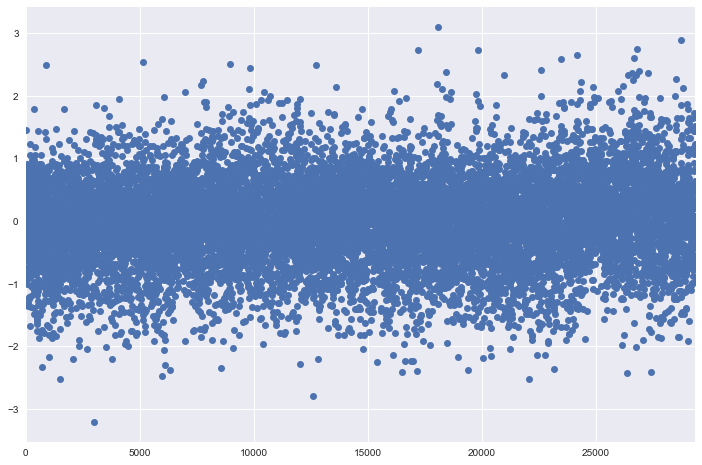

In [30]:
fit3.resid.plot(style='o', figsize=(12,8))

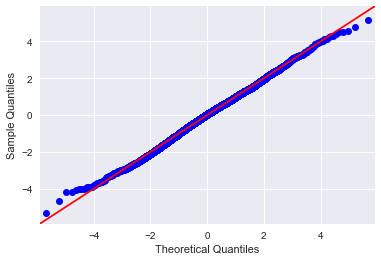

In [31]:
sm.graphics.qqplot(fit3.resid, dist=stats.t, line='45', fit=True);

## Train-Test Split

In [32]:
X4 = X3
y4 = y3

lr = LinearRegression()
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X4, y4, test_size=0.3)
# Fit the model against the training data
lr.fit(X_train, y_train)
# Evaluate the model against the testing data
lr.score(X_test, y_test)

0.4976310863030704

In [33]:
# Score from train set:
lr1 = LinearRegression()
lr1.fit(X4, y4)
lr1.score(X4, y4)

0.51054893740556551

## Cross-Validation - 10-folds, R^2 - sklearn cross validation Kfold

In [34]:
# Filter out p-values below 0.02 using sklearn.cross_validation.Kfold
X5=X4
y5=y4

est=LinearRegression()
from sklearn import feature_selection as f_select

kf=KFold(n=len(X5),n_folds=10,shuffle=True)

all_scores=[]

# Instead of using cross_val_score, let's use sklearn.cross_validation.KFold; this will allow
# us to 'manipulate' our training set, 

# get indices of corresponding train & test
for train,test in kf:
    x_train=X5.iloc[train]
    y_train=y5.iloc[train]
    x_test=X5.iloc[test]
    y_test=y5.iloc[test]
    pvals=[]
    sig_cols=[]
    
    for feature in x_train.columns:
        pval=f_select.f_regression(x_train[[feature]],y_train)
        if pval[1][0]<.02: 
            sig_cols.append(feature)
            pvals.append(pval[1][0])
            
    est.fit(x_train[sig_cols],y_train)
    r_2=est.score(x_test[sig_cols],y_test)
    all_scores.append(r_2)

all_scores
# np.mean(all_scores)

[0.49730790773183742,
 0.51533477258017801,
 0.50006678614998368,
 0.50679213346474228,
 0.5165436986784504,
 0.49935704951561471,
 0.52241640713697002,
 0.48460125788414632,
 0.46850445490694309,
 0.50186986235758235]

## Baseline R^2 score

In [35]:
X_cars = cars4.drop(['make','log_price'],1)
y_cars = cars4.log_price

lr=LinearRegression()

xtrain, xtest, ytrain, ytest = train_test_split(X_cars, y_cars, test_size=0.3)

lr.fit(xtrain, ytrain)
lr.score(xtest, ytest)

0.52594669295912633

## Automatic Cross-Validation with sklearn

In [36]:
rcv = RidgeCV(cv=10)

rcv.fit(X_cars, y_cars)
rcv.score(xtest, ytest)

0.52823959363839434

## Using regularization w/ normalized features

In [37]:
cars4.columns

Index(['make', 'log_price', 'mileage', 'cylinders', 'age', 'van', 'hatch',
       'pickup', 'twodoor', 'fourdoor', 'convertible', 'hardtop', 'coupe',
       'suv', 'ttop', 'sedan', 'wagon', 'awd', 'fwd', 'rwd', 'private',
       'dealer', 'leftdrive', 'rightdrive', 'warranty', 'manual', 'auto',
       'used', 'new', 'cpo', 'title_clear', 'title_salvage', 'title_rebuilt',
       'title_flood', 'title_lemon', 'title_is_clear', 'gas', 'diesel',
       'electric', 'ethanol', 'cng'],
      dtype='object')

In [38]:
# Lets normalize our values (Note: we won't normalize our y value) 

y_car = cars4.log_price
X_car = cars4.drop(['make','log_price'],1)

# Normalize independent features
from sklearn import preprocessing

# this is how we can return our L2 norms (if we want to refer to later)
# axis=0 allows us to normalize on a feature-basis
cars_trans, norm = preprocessing.normalize(X_car,return_norm=True,axis=0)

# turn X back in DF
X_trans=pd.DataFrame(cars_trans,columns=X_car.columns)

## Lasso - Small number of coefficients

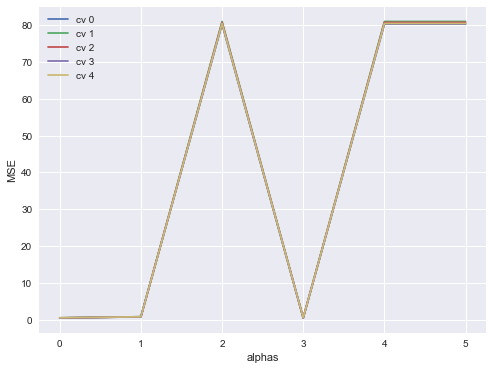

In [39]:
kf = KFold(n=len(X_car), n_folds=5, shuffle=True)

all_scores=[]
alphas=[1e-5,1e-3,1e-1,0,1,100]

for train, test in kf:
    x_train=X_trans.iloc[train]
    y_train=y_car.iloc[train]
    x_test=X_trans.iloc[test]
    y_test=y_car.iloc[test]
    mse_score=[]
    for a in alphas:
        est=Lasso(alpha=a,fit_intercept=False)
        est.fit(x_train,y_train)
        mse=np.mean((y_test-est.predict(x_test))**2)
        mse_score.append(mse)
    all_scores.append(mse_score)
    
plt.figure(figsize=(8,6))
#plt.ylim(0,0.1)
plt.legend()
for i in range(5):
    plt.plot(all_scores[i],label = 'cv %s'%i)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()

In [40]:
# Take a quick look at our strongest features
X_train, X_test, y_train, y_test = train_test_split(X_trans, y_cars, test_size=0.3)

est=Lasso(alpha=1e-5)
est.fit(X_train,y_train)
est.alpha

zipped=zip(X_cars.columns,np.abs(est.coef_))
features=sorted(zipped,key = lambda t: t[1],reverse=True)
features[:5]

[('mileage', 107.59991237907755),
 ('cylinders', 88.004840862608361),
 ('age', 29.87867535476575),
 ('diesel', 20.33801253828166),
 ('fwd', 19.330754590107819)]

In [41]:
X_trans.iloc[0,:10]

mileage       0.003
cylinders     0.005
age           0.001
van           0.000
hatch         0.049
pickup        0.000
twodoor       0.000
fourdoor      0.000
convertible   0.000
hardtop       0.000
Name: 0, dtype: float64